<a href="https://colab.research.google.com/github/Kush-Meta/AnalyticsDashboard/blob/main/PyTorch_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch Tutorial

References:
- https://playground.tensorflow.org/
- Quickstart: https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html
- Linear / fully-connected layers: https://pytorch.org/docs/main/nn.html#linear-layers
  - [`torch.nn.Linear`](https://pytorch.org/docs/main/generated/torch.nn.Linear.html)
- Activation functions: found in https://pytorch.org/docs/main/nn.functional.html
- Loss functions: https://pytorch.org/docs/main/nn.html#loss-functions
  - [`torch.nn.BCELoss`](https://pytorch.org/docs/main/generated/torch.nn.BCELoss.html)
  - [`torch.nn.CrossEntropyLoss`](https://pytorch.org/docs/main/generated/torch.nn.CrossEntropyLoss.html)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm

In [2]:
%config InlineBackend.figure_formats = ['svg']

In [3]:
import torch
from torch import nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [4]:
#@title Run this code block to define plotting helper functions
#@markdown This defines `plot_boundary(X, pred)` which can plot the decision boundary of a neural network
from matplotlib import cm, ticker

MARKERS = ['o', 'v', '+']
COLORS = ['red', 'green', 'blue']
rgb_gradient_cmap = matplotlib.colors.ListedColormap(COLORS)
red_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("RedGradient", [(1, 0, 0, 0), (1, 0, 0, 1)])  # Transparent to red
green_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("GreenGradient", [(0, 1, 0, 0), (0, 1, 0, 1)])  # Transparent to green
blue_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("BlueGradient", [(0, 0, 1, 0), (0, 0, 1, 1)])  # Transparent to blue

def plot_points(X, y):
    for i, label in enumerate(set(y)):
        points = X[y == label]
        marker = MARKERS[i % len(MARKERS)]
        color = COLORS[i % len(COLORS)]
        plt.scatter(points[:,0], points[:,1], marker=marker, color=color)

    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")

def predict(model, x):
    with torch.no_grad():
        o = net(torch.from_numpy(x).float())
    return o.numpy()

def plot_boundary(X, pred, num_classes=2):
    # Define grid limits based on current plot or data
    try:
        x_min, x_max = plt.gca().get_xlim()
        y_min, y_max = plt.gca().get_ylim()
    except:
        x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
        y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1

    # Generate mesh grid
    xs, ys = np.meshgrid(
        np.linspace(x_min, x_max, 200),
        np.linspace(y_min, y_max, 200)
    )
    xys = np.column_stack([xs.ravel(), ys.ravel()])

    # Make predictions over the grid points
    try:
        zs = pred(xys)
        if num_classes == 2:
            # Binary case: plot boundary based on probability threshold 0.5
            zs = zs.reshape(xs.shape)
            plt.contour(xs, ys, (zs >= 0.5).astype(int), colors='grey')
            plt.imshow(zs, cmap="PiYG", vmin=-0.2, vmax=1.2, alpha=0.4, origin='lower', extent=[x_min, x_max, y_min, y_max])
        else:
            # Multi-class case: color - gradient for each
            zzs = np.exp(zs) / np.sum(np.exp(zs), axis=1, keepdims=True)
            Z1 = zzs[:, 0].reshape(xs.shape)
            Z2 = zzs[:, 1].reshape(xs.shape)
            Z3 = zzs[:, 2].reshape(xs.shape)
            plt.imshow(Z1, cmap=red_cmap, origin='lower', alpha=0.6, extent=[x_min, x_max, y_min, y_max])
            plt.imshow(Z2, cmap=green_cmap, origin='lower', alpha=0.6, extent=[x_min, x_max, y_min, y_max])
            plt.imshow(Z3, cmap=blue_cmap, origin='lower', alpha=0.6, extent=[x_min, x_max, y_min, y_max])

            # Multi-class case: boundary - take the argmax over classes
            zs = np.argmax(zs, axis=1).reshape(xs.shape)
            plt.contour(xs, ys, zs, levels=np.arange(num_classes), colors='grey')

            # plt.imshow(zs, cmap=rgb_gradient_cmap, alpha=0.4, origin='lower', extent=[x_min, x_max, y_min, y_max])

    except Exception as e:
        print(f"Error in plotting decision boundary: {e}")
        zs = pred(xys)
        plt.contour(xs, ys, zs.reshape(xs.shape), colors='grey')

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.title("Decision Boundary")

In [5]:
#@title Run this code block to define datasets
#@markdown - `D1(N)`: binary classificaiton, linear decision boundary
#@markdown - `D2(N)`: binary classificaiton, non-linear decision boundary
#@markdown - `D3(N)`: multiclass classification

class D1(Dataset):
    def __init__(self, N=50):
        super().__init__()
        rng = np.random.default_rng(0)
        self.X = np.r_[2.0 * rng.standard_normal((N//2, 2)) - [2, 2], 2.0 * rng.standard_normal((N//2, 2)) + [2, 2]]
        self.y = np.array([0] * (N//2) + [1] * (N//2))

    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx]).float(), torch.tensor([self.y[idx]]).float()

    def __len__(self):
        return len(self.X)


class D2(Dataset):
    def __init__(self, N=50):
        super().__init__()
        rng = np.random.default_rng(0)
        X = 3.0 * rng.standard_normal((N, 2))
        y = np.array([0] * N)
        y[np.diag(X@X.T)>10] = 1
        self.X = X
        self.y = y

    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx]).float(), torch.tensor([self.y[idx]]).float()

    def __len__(self):
        return len(self.X)


class D3(Dataset):
    def __init__(self, N=50):
        super().__init__()
        rng = np.random.default_rng(0)
        X = 3.0 * rng.standard_normal((N, 2))
        y = np.array([0] * N)
        y[np.diag(X@X.T) < 6] = 1
        y[(np.diag(X@X.T) >= 6) & (X@np.array([1,2]) >= 0)] = 2
        self.X = X
        self.y = y

    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx]).float(), torch.tensor(self.y[idx]).long()

    def __len__(self):
        return len(self.X)

## Backprop demo

Linear regression with mean squared error loss

$$ \widehat{y} = w x + b, \; \; L = \frac{1}{2} (\widehat{y} - y)^2 $$

$$\frac{\partial L}{\partial w} = (\widehat{y} - y) x, \;\; \frac{\partial L}{\partial b} = (\widehat{y} - y)$$

We apply SGD with learning rate = 0.1
- Initialize $w = [0,0], b = 0$.
- The point we use to update is $x=[1,2], y=1$.
- $\widehat{y} = ?$, the updated $w = ?, b = ?$


In [6]:
net = nn.Sequential(nn.Linear(2, 1))
optimizer = torch.optim.SGD(net.parameters(), lr=0.1)

In [7]:
# Initialize and clear gradients
nn.init.zeros_(net[0].weight)
nn.init.zeros_(net[0].bias)
try:
    net[0].weight.grad.zero_()
    net[0].bias.grad.zero_()
except:
    pass

print('Initial parameters')
print('w =', net[0].weight.data)
print('b =', net[0].bias.data)

# Forward pass
x = torch.tensor([1,2]).float()
y_true = torch.tensor([1]).float()
y_hat = net(x)  # <-- FILL IN THIS LINE
loss = 0.5 * (y_hat - y_true)**2   # <-- FILL IN THIS LINE
print()
print('Forward pass')
print('y_hat =', y_hat.data)
print('loss. =', loss.data)

# Backward pass
loss.backward()          # <-- FILL IN THIS LINE
print()
print('Gradients')
print('dw =', net[0].weight.grad)
print('db =', net[0].bias.grad)

# Update
optimizer.step()         # <-- FILL IN THIS LINE
print()
print('Updated parameters')
print('w =', net[0].weight.data)
print('b =', net[0].bias.data)

Initial parameters
w = tensor([[0., 0.]])
b = tensor([0.])

Forward pass
y_hat = tensor([0.])
loss. = tensor([0.5000])

Gradients
dw = tensor([[-1., -2.]])
db = tensor([-1.])

Updated parameters
w = tensor([[0.1000, 0.2000]])
b = tensor([0.1000])


## Neural Net Training - Example (Logistic Regression)

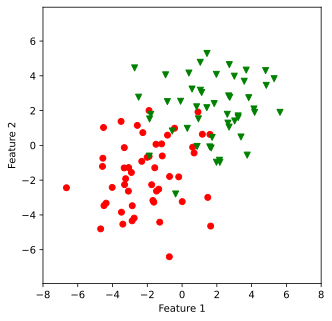

In [8]:
d1 = D1(100)
plt.figure(figsize=(5,5))
plot_points(d1.X, d1.y)
plt.axis('equal')
plt.xlim(-8, 8)
plt.ylim(-8, 8)
plt.show()

### Define the neural network

In [9]:
class Net1(nn.Module):
    def __init__(self):
        super().__init__()
        # TODO: put neural net structure here
        self.linear = nn.Linear(2, 1)

    def forward(self, x):
        # TODO: define the forward pass here
        return torch.sigmoid(self.linear(x))

In [10]:
torch.random.manual_seed(2)
net = Net1()

In [11]:
# How many float-valued parameters are there?
print('Number of learnable float-valued parameters', count_parameters(net))
print('Neural net architecture:')
print(net)

Number of learnable float-valued parameters 3
Neural net architecture:
Net1(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)


### Before training...

In [12]:
# What are the parameter values before training?
for name, param in net.named_parameters():
    print(name, '\t', param.data)

linear.weight 	 tensor([[ 0.1622, -0.1683]])
linear.bias 	 tensor([0.1939])


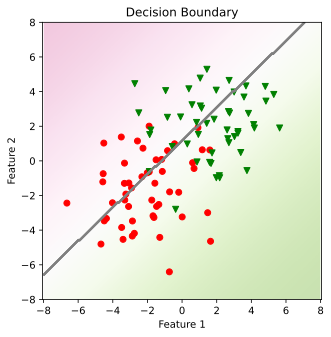

In [13]:
# Where is the decision boundary before training?
plt.figure(figsize=(5,5))
plot_points(d1.X, d1.y)
plt.axis('equal')
plt.xlim(-8, 8)
plt.ylim(-8, 8)
plot_boundary(d1.X, lambda x: predict(net, x))
plt.show()

### Train!

In [15]:
# Training set, loss function, and optimization algorithm
dataloader = DataLoader(d1, batch_size=4, shuffle=True)
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.1)

In [16]:
# Trainer loop
for epoch in tqdm(range(1000)):
    for X, y in dataloader:
        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        y_hat = net(X)

        # Compute loss
        loss = criterion(y_hat, y)

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

100%|██████████| 1000/1000 [00:18<00:00, 53.15it/s]


### After training...

In [17]:
# What are the parameter values before training?
for name, param in net.named_parameters():
    print(name, '\t', param.data)

linear.weight 	 tensor([[0.8358, 0.8973]])
linear.bias 	 tensor([-0.1503])


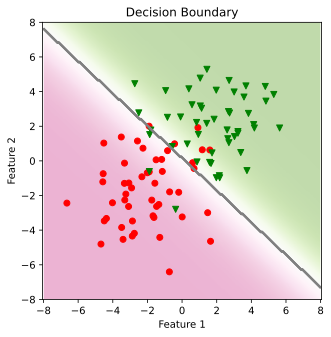

In [18]:
# Where is the decision boundary after training?
plt.figure(figsize=(5,5))
plot_points(d1.X, d1.y)
plt.axis('equal')
plt.xlim(-8, 8)
plt.ylim(-8, 8)
plot_boundary(d1.X, lambda x: predict(net, x))
plt.show()

## Exercise Q2: non-linear decision boundary

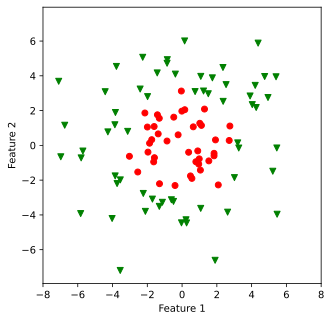

In [19]:
# Data
d2 = D2(100)
plt.figure(figsize=(5,5))
plot_points(d2.X, d2.y)
plt.axis('equal')
plt.xlim(-8, 8)
plt.ylim(-8, 8)
plt.show()

In [22]:
# Model
class Net2(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 10)
        self.fc2 = nn.Linear(10, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return torch.sigmoid(self.fc2(x))

net = Net2()

print('Number of learnable float-valued parameters', count_parameters(net))
print('Neural net architecture:')
print(net)

Number of learnable float-valued parameters 41
Neural net architecture:
Net2(
  (fc1): Linear(in_features=2, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=1, bias=True)
)


In [20]:
# What are the parameter values before training?
for name, param in net.named_parameters():
    print(name, '\t', param.data)

linear.weight 	 tensor([[0.8358, 0.8973]])
linear.bias 	 tensor([-0.1503])


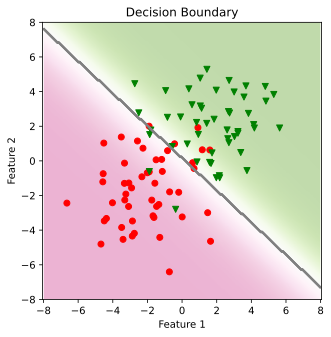

In [21]:
# Where is the decision boundary after training?
plt.figure(figsize=(5,5))
plot_points(d1.X, d1.y)
plt.axis('equal')
plt.xlim(-8, 8)
plt.ylim(-8, 8)
plot_boundary(d1.X, lambda x: predict(net, x))
plt.show()

fc1.weight 	 tensor([[-0.1096, -0.2154],
        [-0.0301, -0.3468],
        [-0.6656,  0.2079],
        [ 0.0177, -0.0134],
        [-0.3668,  0.4844],
        [ 0.5719, -0.1783],
        [-0.6704,  0.2640],
        [-0.6724,  0.2344],
        [-0.4915, -0.5061],
        [-0.3761,  0.3513]])
fc1.bias 	 tensor([ 0.1843,  0.1735,  0.6499, -0.1210,  0.2878,  0.4035,  0.4849, -0.6881,
        -0.3827, -0.6977])
fc2.weight 	 tensor([[-0.0885,  0.0984, -0.1456, -0.1760, -0.1301,  0.0122, -0.0342,  0.0057,
          0.1664, -0.2750]])
fc2.bias 	 tensor([-0.1394])


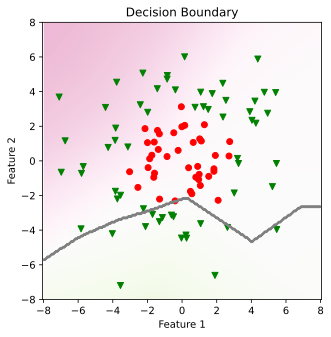

In [23]:
# What are the parameter values before training?
for name, param in net.named_parameters():
    print(name, '\t', param.data)

# Where is the decision boundary before training?
plt.figure(figsize=(5,5))
plot_points(d2.X, d2.y)
plt.axis('equal')
plt.xlim(-8, 8)
plt.ylim(-8, 8)
plot_boundary(d2.X, lambda x: predict(net, x))
plt.show()

In [ ]:
# What are the parameter values after training?
for name, param in net.named_parameters():
    print(name, '\t', param.data)

# Where is the decision boundary after training?
plt.figure(figsize=(5,5))
plot_points(d2.X, d2.y)
plt.axis('equal')
plt.xlim(-8, 8)
plt.ylim(-8, 8)
plot_boundary(d2.X, lambda x: predict(net, x))
plt.show()

In [24]:
# Training set, loss function, and optimization algorithm
dataloader = DataLoader(d2, batch_size=4, shuffle=True)
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.1)

# Trainer loop
for epoch in tqdm(range(1000)):
    for X, y in dataloader:
        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        y_hat = net(X)

        # Compute loss
        loss = criterion(y_hat, y)

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

100%|██████████| 1000/1000 [00:25<00:00, 39.92it/s]


## Exercise Q3: three-way classification

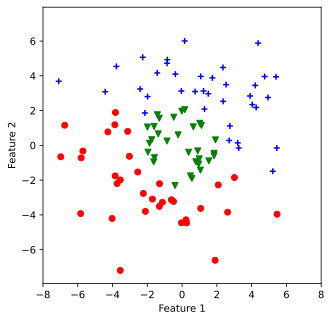

In [25]:
# Data...
d3 = D3(100)
plt.figure(figsize=(5,5))
plot_points(d3.X, d3.y)
plt.axis('equal')
plt.xlim(-8, 8)
plt.ylim(-8, 8)
plt.show()

fc1.weight 	 tensor([[-0.1534,  0.0389],
        [ 1.0977, -2.2992],
        [-0.3478,  0.1511],
        [ 0.0159, -0.0071],
        [-1.0225,  3.3532],
        [ 3.1233,  0.9065],
        [-0.9795, -0.0178],
        [-2.2237,  0.8520],
        [-2.5650, -2.4533],
        [-0.4705,  1.2954]])
fc1.bias 	 tensor([ 2.5597, -0.7253,  5.6209, -0.1220, -0.9198, -2.6848,  0.7847, -2.7603,
        -0.8966, -0.6123])
fc2.weight 	 tensor([[-2.2384,  2.5342, -4.9077, -0.1760,  3.3687,  3.8709, -0.9896,  3.3254,
          3.4519,  1.1346]])
fc2.bias 	 tensor([-3.7328])


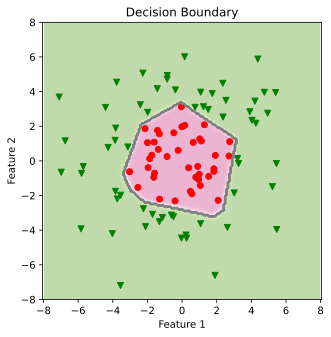

In [27]:
# What are the parameter values after training?
for name, param in net.named_parameters():
    print(name, '\t', param.data)

# Where is the decision boundary after training?
plt.figure(figsize=(5,5))
plot_points(d2.X, d2.y)
plt.axis('equal')
plt.xlim(-8, 8)
plt.ylim(-8, 8)
plot_boundary(d2.X, lambda x: predict(net, x))
plt.show()

In [30]:
# Model...
class Net3(nn.Module):
    def __init__(self):
        super().__init__()
        # TODO: put neural net structure here
        self.fc1 = nn.Linear(2, 10)  # Input (2 features) to hidden layer (10 neurons)
        self.fc2 = nn.Linear(10, 3)  # Hidden layer (10 neurons) to output layer (3 neurons for 3 classes)

    def forward(self, x):
        # TODO: define the forward pass here
        x = F.relu(self.fc1(x)) # Apply ReLU activation to the output of the first linear layer
        return self.fc2(x) # Return raw logits for CrossEntropyLoss

torch.random.manual_seed(1)
net = Net3()

print('Number of learnable float-valued parameters', count_parameters(net))
print('Neural net architecture:')
print(net)

Number of learnable float-valued parameters 63
Neural net architecture:
Net3(
  (fc1): Linear(in_features=2, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=3, bias=True)
)


fc1.weight 	 tensor([[ 0.3643, -0.3121],
        [-0.1371,  0.3319],
        [-0.6657,  0.4241],
        [-0.1455,  0.3597],
        [ 0.0983, -0.0866],
        [ 0.1961,  0.0349],
        [ 0.2583, -0.2756],
        [-0.0516, -0.0637],
        [ 0.1025, -0.0028],
        [ 0.6181,  0.2200]])
fc1.bias 	 tensor([-0.2633, -0.4271, -0.1185, -0.3050, -0.2266,  0.0339,  0.4215,  0.3843,
        -0.6912,  0.4383])
fc2.weight 	 tensor([[ 0.0883,  0.3000,  0.2087, -0.2881, -0.3007, -0.1525,  0.2777, -0.0527,
          0.1353, -0.1470],
        [ 0.3103, -0.1338,  0.2371,  0.0037, -0.1666,  0.1625, -0.1679,  0.0930,
         -0.0913, -0.0347],
        [-0.3040, -0.1508,  0.1716, -0.0769,  0.3150,  0.2535, -0.0148, -0.2111,
          0.1926,  0.0981]])
fc2.bias 	 tensor([-0.2044,  0.2054,  0.1920])


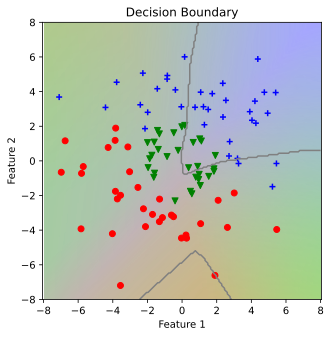

In [31]:
# Before training...

# What are the parameter values before training?
for name, param in net.named_parameters():
    print(name, '\t', param.data)

# Where is the decision boundary before training?
plt.figure(figsize=(5,5))
plot_points(d3.X, d3.y)
plt.axis('equal')
plt.xlim(-8, 8)
plt.ylim(-8, 8)
plot_boundary(d3.X, lambda x: predict(net, x), num_classes=3)
plt.show()

In [32]:
# Train...

# Training set, loss function, and optimization algorithm
dataloader = DataLoader(d3, batch_size=4, shuffle=True)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.1)

# Trainer loop
for epoch in tqdm(range(1000)):
    for X, y in dataloader:
        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        y_hat = net(X)

        # Compute loss
        loss = criterion(y_hat, y)

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

100%|██████████| 1000/1000 [00:25<00:00, 39.31it/s]


/tmp/ipython-input-960418041.py:53: RuntimeWarning: overflow encountered in exp
  zzs = np.exp(zs) / np.sum(np.exp(zs), axis=1, keepdims=True)
/tmp/ipython-input-960418041.py:53: RuntimeWarning: invalid value encountered in divide
  zzs = np.exp(zs) / np.sum(np.exp(zs), axis=1, keepdims=True)


fc1.weight 	 tensor([[-9.2948e-02, -2.3054e+00],
        [-1.3502e+00,  1.1386e+00],
        [-2.5661e+00, -3.2650e-01],
        [-1.9208e-02,  2.1758e+00],
        [ 3.0119e+00, -5.7241e-02],
        [ 7.3978e-01,  1.2036e+00],
        [-6.1117e-01, -2.1920e+00],
        [-4.6409e-02, -7.4376e-01],
        [ 1.0249e-01, -2.8248e-03],
        [ 1.1366e+00,  1.9749e+00]])
fc1.bias 	 tensor([-1.0779, -2.0536, -1.7608, -1.6833, -0.8366,  0.5489, -0.4826,  4.9156,
        -0.6912,  0.6107])
fc2.weight 	 tensor([[ 1.9517,  0.7151,  2.0069, -0.9744,  0.7139, -0.9876,  1.8196, -0.8461,
          0.1353, -1.4831],
        [-1.4840, -2.1983, -2.3167, -1.1966, -2.5403,  0.2784, -0.9362,  3.5549,
         -0.0913, -0.0875],
        [-0.3731,  1.4986,  0.9273,  1.8098,  1.6742,  0.9728, -0.7883, -2.8795,
          0.1926,  1.4872]])
fc2.bias 	 tensor([-1.2713,  2.7885, -1.3241])


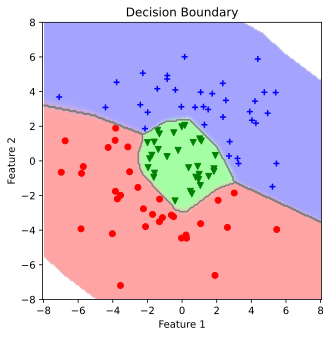

In [33]:
# After training...

# What are the parameter values after training?
for name, param in net.named_parameters():
    print(name, '\t', param.data)

# Where is the decision boundary after training?
plt.figure(figsize=(5,5))
plot_points(d3.X, d3.y)
plt.axis('equal')
plt.xlim(-8, 8)
plt.ylim(-8, 8)
plot_boundary(d3.X, lambda x: predict(net, x), num_classes=3)
plt.show()

/tmp/ipython-input-960418041.py:53: RuntimeWarning: overflow encountered in exp
  zzs = np.exp(zs) / np.sum(np.exp(zs), axis=1, keepdims=True)
/tmp/ipython-input-960418041.py:53: RuntimeWarning: invalid value encountered in divide
  zzs = np.exp(zs) / np.sum(np.exp(zs), axis=1, keepdims=True)


fc1.weight 	 tensor([[-9.2948e-02, -2.3054e+00],
        [-1.3502e+00,  1.1386e+00],
        [-2.5661e+00, -3.2650e-01],
        [-1.9208e-02,  2.1758e+00],
        [ 3.0119e+00, -5.7241e-02],
        [ 7.3978e-01,  1.2036e+00],
        [-6.1117e-01, -2.1920e+00],
        [-4.6409e-02, -7.4376e-01],
        [ 1.0249e-01, -2.8248e-03],
        [ 1.1366e+00,  1.9749e+00]])
fc1.bias 	 tensor([-1.0779, -2.0536, -1.7608, -1.6833, -0.8366,  0.5489, -0.4826,  4.9156,
        -0.6912,  0.6107])
fc2.weight 	 tensor([[ 1.9517,  0.7151,  2.0069, -0.9744,  0.7139, -0.9876,  1.8196, -0.8461,
          0.1353, -1.4831],
        [-1.4840, -2.1983, -2.3167, -1.1966, -2.5403,  0.2784, -0.9362,  3.5549,
         -0.0913, -0.0875],
        [-0.3731,  1.4986,  0.9273,  1.8098,  1.6742,  0.9728, -0.7883, -2.8795,
          0.1926,  1.4872]])
fc2.bias 	 tensor([-1.2713,  2.7885, -1.3241])


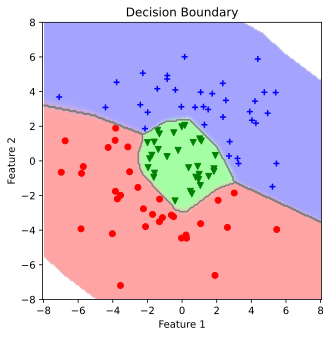

In [34]:
# After training...

# What are the parameter values after training?
for name, param in net.named_parameters():
    print(name, '\t', param.data)

# Where is the decision boundary after training?
plt.figure(figsize=(5,5))
plot_points(d3.X, d3.y)
plt.axis('equal')
plt.xlim(-8, 8)
plt.ylim(-8, 8)
plot_boundary(d3.X, lambda x: predict(net, x), num_classes=3)
plt.show()

## Exercise Q4: Architecture Choices & Effects

# Task
Complete Net2 Training Block: Fill in the dataloader, criterion, optimizer, and trainer loop sections in cell `iB789iKayPGH` for training the Net2 model on the `d2` dataset.

## Complete Net2 Training Block

### Subtask:
Fill in the dataloader, criterion, optimizer, and trainer loop sections in cell `iB789iKayPGH` for training the Net2 model on the d2 dataset.


## Summary:

### Data Analysis Key Findings
No data analysis findings are available as this task focused on setting up the training block for Net2.

### Insights or Next Steps
*   The Net2 training block has been successfully set up, including the dataloader, criterion, optimizer, and the trainer loop in the specified cell.
*   The next logical step is to execute the completed training block to train Net2 on the `d2` dataset and then evaluate its performance.
